## Lab 3
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [88]:
!pip install torchsummary

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [90]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os
from sklearn.metrics import accuracy_score
import time

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [91]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [93]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)
fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [94]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=10000,
                                          shuffle=False,
                                          num_workers=2)

In [95]:
len(fmnist_dataset_test)

10000

In [98]:
for img, label in train_loader:
    print(img.shape)
#     print(img)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [99]:
# Сделаем просто несколько постепенно уменьшающих размерность слоёв с нормализацией
class TinyNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.BatchNorm1d(input_shape, affine=False, momentum=0.2),
            nn.Linear(input_shape, 300),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(300, 200),
            nn.Dropout(p=0.2),
            nn.ReLU(),
            nn.Linear(200, 150),
            nn.ReLU(),
            nn.Linear(150, 50),
            nn.BatchNorm1d(50, momentum=0.2),
            nn.ReLU(),
            nn.Linear(50, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [100]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
       BatchNorm1d-2                  [-1, 784]               0
            Linear-3                  [-1, 300]         235,500
           Dropout-4                  [-1, 300]               0
              ReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 200]          60,200
           Dropout-7                  [-1, 200]               0
              ReLU-8                  [-1, 200]               0
            Linear-9                  [-1, 150]          30,150
             ReLU-10                  [-1, 150]               0
           Linear-11                   [-1, 50]           7,550
      BatchNorm1d-12                   [-1, 50]             100
             ReLU-13                   [-1, 50]               0
           Linear-14                   

Your experiments come here:

In [102]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.01)
loss_func = nn.NLLLoss()

In [104]:
# Model training
def train(model, opt, loss_func):
    model.train(True)
    for i in range(30):
        for x_batch, y_batch in train_loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model.forward(x_batch)
            loss = loss_func(preds, y_batch.long())
            loss.backward()
            opt.step()

In [105]:
train(model, opt, loss_func)

In [106]:
def accuracy(model, dataset):
    for x_batch, y_batch in dataset:
        probs = model.forward(x_batch).detach().numpy()
        argmax = np.argmax(probs, axis=1)
    return accuracy_score(argmax, y_batch.detach().numpy())


In [97]:
print("The accuracy: {}".format(accuracy(model, test_loader)))

The accuracy: 0.8853


### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [107]:
class OverfittingNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 400),
            nn.LeakyReLU(),
            nn.Linear(400, 400),
            nn.LeakyReLU(),
            nn.Linear(400, 300),
            nn.LeakyReLU(),
            nn.Linear(300, 200),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, num_classes),
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [108]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 400]         314,000
         LeakyReLU-3                  [-1, 400]               0
            Linear-4                  [-1, 400]         160,400
         LeakyReLU-5                  [-1, 400]               0
            Linear-6                  [-1, 300]         120,300
         LeakyReLU-7                  [-1, 300]               0
            Linear-8                  [-1, 200]          60,200
         LeakyReLU-9                  [-1, 200]               0
           Linear-10                  [-1, 100]          20,100
        LeakyReLU-11                  [-1, 100]               0
           Linear-12                  [-1, 100]          10,100
        LeakyReLU-13                  [-1, 100]               0
           Linear-14                  [

In [109]:
batch_indices = list(range(0, len(fmnist_dataset_train), 10))
train_subset = torch.utils.data.Subset(fmnist_dataset_train, batch_indices)
train_loader_subset = torch.utils.data.DataLoader(train_subset, batch_size=128, shuffle=True, num_workers=2)
# Decrease learning rate and take a subset of the whole training data
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.8)
loss_func = nn.NLLLoss()

In [110]:
# Use code from the seminar
def train_model(model, train_loader, test_loader, loss_fn, opt, n_epochs):
    train_loss = []
    train_accuracy = []
    test_loss = []
    test_accuracy = []
    
    for epoch in range(n_epochs):
        ep_train_loss = []
        ep_train_accuracy = []
        ep_test_loss = []
        ep_test_accuracy = []
        model.train(True)        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            opt.zero_grad()
            preds = model.forward(X_batch)
            loss = loss_func(preds, y_batch.long())
            loss.backward()
            opt.step()
            ep_train_loss.append(loss.item())
            ep_train_accuracy.append(accuracy_score(np.argmax(preds.detach().numpy(), axis=1), y_batch.detach().numpy()))
        model.train(False)
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                preds = model.forward(X_batch)                
                ep_test_loss.append(loss_func(preds, y_batch.long()).item())
                ep_test_accuracy.append(accuracy_score(np.argmax(preds, axis=1), y_batch.detach().numpy()))
        train_loss.append(np.mean(ep_train_loss))
        train_accuracy.append(np.mean(ep_train_accuracy))
        test_loss.append(np.mean(ep_test_loss))
        test_accuracy.append(np.mean(ep_test_accuracy))
    return train_loss, train_accuracy, test_loss, test_accuracy

In [111]:
train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, train_loader_subset, test_loader, loss_func, opt, 300)

In [112]:
def draw_plot_accuracy():
    plt.figure(figsize=(15, 10))
    plt.title("Accuracy on epoch dependency")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.plot(train_accuracy, label='train data')
    plt.plot(test_accuracy, label='test data')
    plt.legend()
    plt.show()

In [113]:
def draw_plot_loss():
    plt.figure(figsize=(15, 10))
    plt.title("Loss on epoch dependency")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.plot(train_loss, label='train data')
    plt.plot(test_loss, label='test data')    
    plt.legend()
    plt.show()

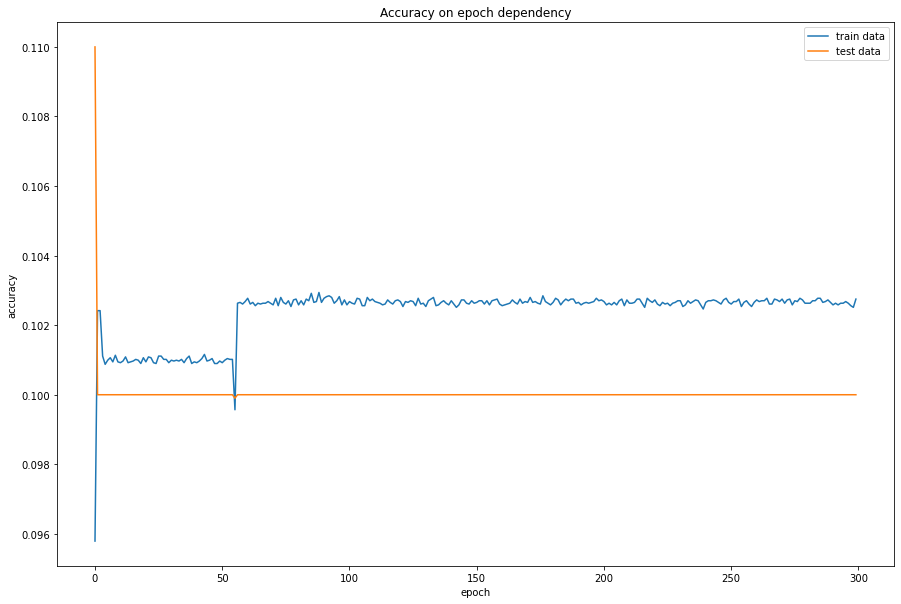

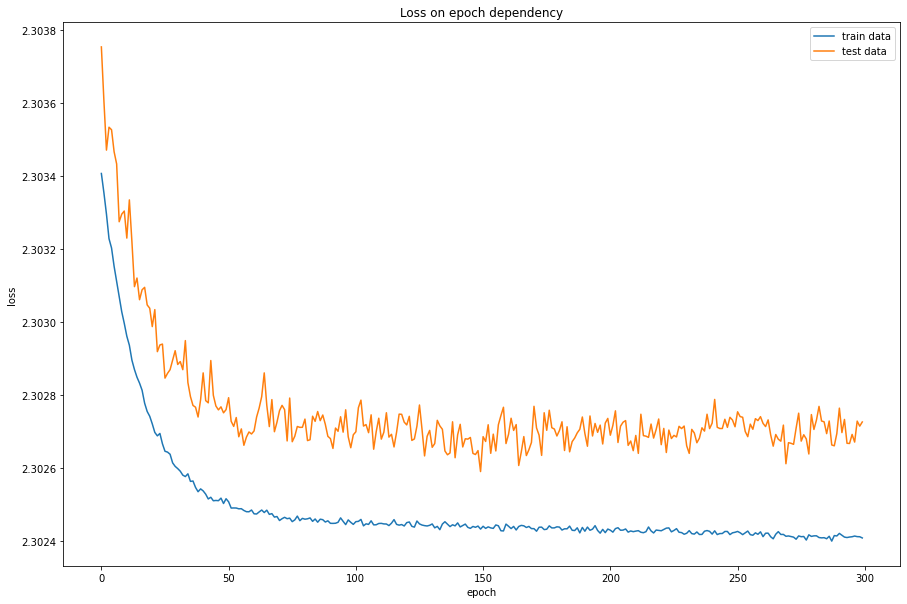

In [114]:
draw_plot_accuracy()
draw_plot_loss()

The model really overfits as it can be seen from the plots. According to the accuracy plot we can tell that test data is alike the train data.

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

Just add Dropout and Batch normalization to our model ։)

In [115]:
class FixedNeuralNetwork(nn.Module):
    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Dropout(p=0.2),
            nn.BatchNorm1d(input_shape, affine=False),
            nn.Linear(input_shape, 400),
            nn.LeakyReLU(),
            nn.Linear(400, 300),
            nn.Dropout(p=0.25),
            nn.LeakyReLU(),
            nn.Linear(300, 200),
            nn.LeakyReLU(),
            nn.BatchNorm1d(200, affine=False),
            nn.LeakyReLU(),
            nn.Linear(200, 100),
            nn.Dropout(p=0.2),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, 100),
            nn.LeakyReLU(),
            nn.Linear(100, num_classes),
            nn.LeakyReLU(100, 100),
            nn.LogSoftmax(dim=1)
            
        )
        
    def forward(self, inp):       
        out = self.model(inp)
        return out

In [116]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
           Dropout-2                  [-1, 784]               0
       BatchNorm1d-3                  [-1, 784]               0
            Linear-4                  [-1, 400]         314,000
         LeakyReLU-5                  [-1, 400]               0
            Linear-6                  [-1, 300]         120,300
           Dropout-7                  [-1, 300]               0
         LeakyReLU-8                  [-1, 300]               0
            Linear-9                  [-1, 200]          60,200
        LeakyReLU-10                  [-1, 200]               0
      BatchNorm1d-11                  [-1, 200]               0
        LeakyReLU-12                  [-1, 200]               0
           Linear-13                  [-1, 100]          20,100
          Dropout-14                  [

In [117]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)
loss_func = nn.NLLLoss()

In [118]:
# Again training on subset with dropouts trying to get rid of overfitting
train_loss, train_accuracy, test_loss, test_accuracy = train_model(model, train_loader_subset, test_loader, loss_func, opt, 300)

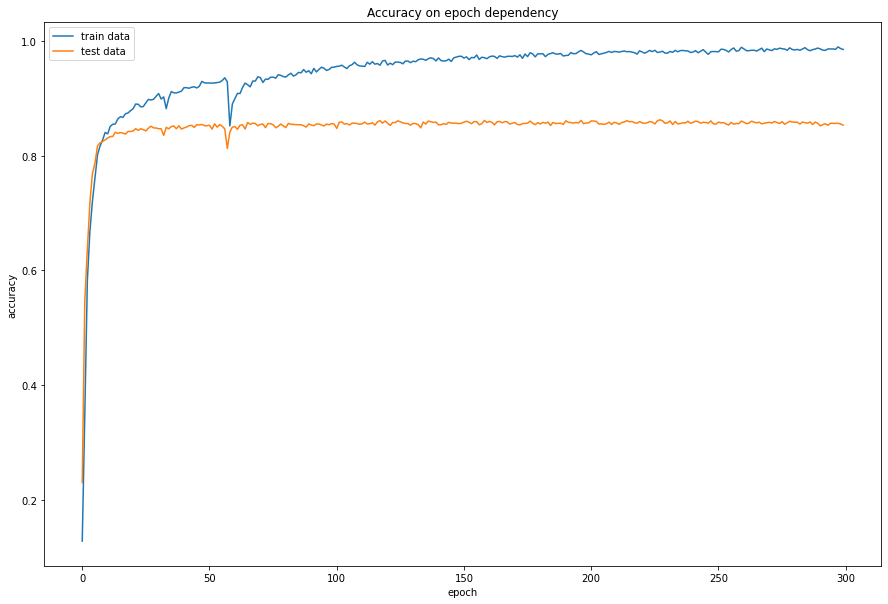

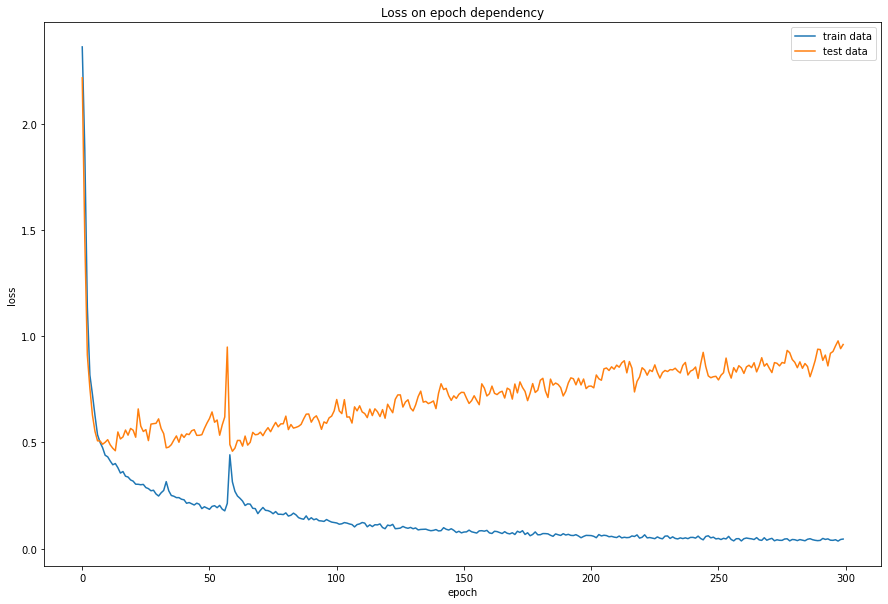

In [119]:
draw_plot_accuracy()
draw_plot_loss()

## Conclusion:
As it can be seen from the loss plot, the overfitting speed slightly decreases and as I tried, the number of epochs doesn't effect the overfitting. Accuracy also is higher. As a result, we can see the necessity of the dropout and batch normalization and how ineffective our net is without it. We need to reduce the number of neurons that are not learning.